In [2]:
# 분석 환경
!systeminfo | findstr OS.이름
!systeminfo | findstr based
!python -V

OS 이름:                 Microsoft Windows 10 Home
시스템 종류:             x64-based PC
Python 3.7.3


### 문제1 : 가설검정

+ **개요**
  + '더치페이 요청에 대한 응답률이 높을수록 더치페이 서비스를 더 많이 사용한다.' 라는 전제에서 시작한다.
  + 가설 : 서로 다른 두 서비스(더치페이 요청, 더치페이 서비스 사용금액) 간 양의 상관관계가 있는지에 대한 검정이 필요다.
  + 따라서, 1) 일반적인 상관계수 검증방법인 피어슨 상관계수와 2)스피어만 상관계수 및 3) 켄달의 tua를 이용하여 가설을 검증하고자 한다.


+ **용어의 정의**
  + 더치페이 요청에 대한 응답률(A) : 개별 더치페이 요청에 대한 응답율(=SEND/SEND+CLAIM)의 개인별 평균값으로 정의함 
  + 더치페이 서비스 사용(B1) : 각 개인의 더치페이 응답(SEND)으로 정의함
  + 더치페이 서비스 사용(B2) : 각 개인의 더치페이 응답(SEND)과 요청(CHECK)의 합으로 정의함


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)                               # 한글폰트 설정(전역)

from scipy import stats

In [3]:
# 데이터 불러오기
users = pd.read_csv('./data/users.csv')
a_payment_trx = pd.read_csv('./data/a_payment_trx.csv')
dutchpay_claim = pd.read_csv('./data/dutchpay_claim.csv')
dutchpay_claim_detail = pd.read_csv('./data/dutchpay_claim_detail.csv')

# Data type 변경
users['gender_cd'] = users['gender_cd'].astype('object')

a_payment_trx['transaction_id'] = a_payment_trx['transaction_id'].astype('object')
a_payment_trx['transacted_at'] = pd.to_datetime(a_payment_trx['transacted_at']).dt.date 

dutchpay_claim['claim_id'] = dutchpay_claim['claim_id'].astype('object')
dutchpay_claim['claim_at'] = pd.to_datetime(dutchpay_claim['claim_at']).dt.date 

dutchpay_claim_detail['claim_detail_id'] = dutchpay_claim_detail['claim_detail_id'].astype('object')
dutchpay_claim_detail['claim_id'] = dutchpay_claim_detail['claim_id'].astype('object')

In [4]:
# 더치페이 요청에 대한 응답률(A)
df_temp1 = dutchpay_claim_detail[dutchpay_claim_detail['status']!= 'CHECK']
df_temp1 = pd.DataFrame(df_temp1.groupby('claim_id', as_index=False)['claim_amount'].count())
df_temp1.rename(columns = {'claim_amount' : 'claim_count'}, inplace = True)
# df_temp1 = df_temp1[['claim_id','claim_user_id', 'claim_amount']]
df_temp1 = pd.merge(dutchpay_claim, df_temp1, on='claim_id', how='left' )

df_temp2 = dutchpay_claim_detail[dutchpay_claim_detail['status']!= 'CHECK']
df_temp2 = df_temp2[df_temp2['send_amount'] > 0]
df_temp2 = pd.DataFrame(df_temp2.groupby('claim_id', as_index=False)['claim_amount'].count())
df_temp2.rename(columns = {'claim_amount' : 'response_count'}, inplace = True)

df_response = pd.merge(df_temp1, df_temp2, on='claim_id', how ='left' ) 
df_response['ratio'] = df_response['response_count']/ df_response['claim_count']
df_response = df_response.dropna()

df_response = pd.DataFrame(df_response.groupby('claim_user_id', as_index=False)['ratio'].mean())
df_response.rename(columns = {'ratio' : 'claim_ratio'}, inplace = True)

In [5]:
#더치페이 서비스 사용(B1)
df_temp3 = dutchpay_claim_detail[dutchpay_claim_detail['status']== 'SEND'].dropna()
df_temp3 = pd.merge(dutchpay_claim, df_temp3, on='claim_id',how='left')

df_temp3 = pd.DataFrame(df_temp3.groupby('claim_user_id', as_index=False)['status'].count())
df_temp3.rename(columns = {'status' : 'request_count_B1'}, inplace = True)

In [6]:
#더치페이 서비스 사용(B2)
df_temp4 = dutchpay_claim_detail[dutchpay_claim_detail['status']!= 'CLAIM'].dropna()
df_temp4 = pd.merge(dutchpay_claim, df_temp4, on='claim_id',how='left')

df_temp4 = pd.DataFrame(df_temp4.groupby('claim_user_id', as_index=False)['status'].count())
df_temp4.rename(columns = {'status' : 'request_count_B2'}, inplace = True)

In [7]:
# 결과 합치기(A & B1, B2)
df_response2 = pd.merge(df_response , df_temp3, on='claim_user_id', how='left')
df_response2 = pd.merge(df_response2, df_temp4, on='claim_user_id', how='left')

df_response2 = df_response2.dropna()
df_response2 = df_response2[df_response2['request_count_B1']>0]

In [8]:
# 결과 확인
df_response2.tail()

,claim_user_id,claim_ratio,request_count_B1,request_count_B2
32569,fffb1cc5088697c,0.750000,3,4
32570,fffb57a1a9167c1,0.500000,2,4
32571,fffc8ef9e25e9d8,0.500000,1,2
32572,fffe75ca19b49be,0.694444,5,9
32573,ffffc4e9501da7c,1.000000,3,6


In [9]:
# df_response2.info()

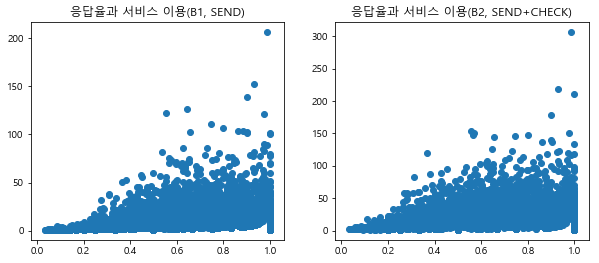

In [10]:
# 결과 시각화
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.title("응답율과 서비스 이용(B1, SEND)")
plt.scatter(df_response2.claim_ratio, df_response2.request_count_B1)

plt.subplot(1,2,2)
plt.title("응답율과 서비스 이용(B2, SEND+CHECK)")
plt.scatter(df_response2.claim_ratio, df_response2.request_count_B2)

plt.show()

+ **중간결과 : 변수내용**
  + 서비스 이용의 경우, 정의가 모호하여, 두가지로 나우어 진행함
  + 단, 두 결과(B1, B2) 사이의 큰 차이는 없으므로, scale이 낮은 B1을 이용하여 상관관계에 대한 가설검정을 진행함  

+ **가설**
  + A와 B사이에 양의 상관관계가 있다는 것을 가정하므로, 단방향 검정을 하고자 한다.
  + 검정통계량은 1)스피어만 상관계수, 2)스피어만 상관계수, 3)켄달의 tau를 이용한다.
  + 아울러, 유의수준($\alpha$)은 5%로 설정한다.(즉, 기각역 : p-value > 0.05)
  
  + $H_0$ : $\rho > 0$

  + $H_1$ : $\rho = 0$


In [11]:
# 피어슨 상관계수
stats.pearsonr(df_response2.claim_ratio, df_response2.request_count_B1)

(0.15455716384188767, 2.8042385827474305e-173)

In [12]:
# 스피어만 상관계수
stats.spearmanr(df_response2.claim_ratio, df_response2.request_count_B1)

SpearmanrResult(correlation=0.279468447265759, pvalue=0.0)

In [13]:
# 켄달의 tau
stats.kendalltau(df_response2.claim_ratio, df_response2.request_count_B1)

KendalltauResult(correlation=0.207673237531586, pvalue=0.0)

+ **가설검정 결과**
  + A와 B사이에는 양의 상관관계가 있으며 이는 통계적으로 유의미한 수준이다. 
    + 1)피어슨 상관계수 : 0.1546
    + 2)스피어만 상관계수 : 0.2795
    + 3)켄달의 tau : 0.2077 
  + 상관관계에 대한 하나의 수치만 골라야 한다면, 켄달의 tau(0.2077)를 이용하고자 함
  + 이유는, 두 변수사이의 scale이 맞지 않기 때문에, 결과에 대한 영향력이 적은 켄달의 tau를 선택하게 됨 (켄달의 tau는 각 변수의 순위를 기반으로 계산하기 때문에, 자료의 scale에 따른 문제가 발생하지 않음)
  
  
+ **결론**
  + '19/12 ~ '20/02 까지, 더치페이 서비스를 이용한 32,574명의 자료에 대해, 상관계수를 계산함.
  + 계산된 상관계수는 통계적으로 의미있는 수치이다.
  + 다만, 결과값 모두 .015 ~ 0.27 사이이므로, 이를 활용한 서비스 개발/비지니스적인 활용은 어렵다고 판단됨.

### 문제2 : Query 작성
+ BigQuery에 자료를 임시로 올린 뒤, 작업을 진행함
+ [더치페이를 요청]한 인원 중, [12월]에 A가맹점에서 [순결제가 1만원 이상]인 고객은 1,537명 이다.
+ (단, 순결제는 구매-취소 이며, 취소는 2월까지 자료를 반영함) 

In [14]:
import os
from google.cloud import bigquery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:/vision API-06a448b64428.json"
client = bigquery.Client()

%load_ext google.cloud.bigquery

In [15]:
%%bigquery

select user_id, sum(amount) as amount 
from (
    /* a가맹점 취소자료 */
    SELECT B1.user_id, -1*B1.amount as amount, FORMAT_DATETIME('%y/%m/%d', CAST(B1.transacted_at AS DATETIME)) as DATE
    FROM  `thermal-rain-234004.cust_test.a_payment_trx` B1, `thermal-rain-234004.cust_test.dutchpay_claim` A
    where A.claim_user_id = B1.user_id
    and B1.payment_action_type = 'CANCEL'
    and FORMAT_DATETIME('%y/%m/%d', CAST(B1.transacted_at AS DATETIME)) between '19/12/01' and '20/02/28'

    union all 
    
    /* a가맹점 결제자료 */
    SELECT B2.user_id, B2.amount as amount, FORMAT_DATETIME('%y/%m/%d', CAST(B2.transacted_at AS DATETIME)) as DATE
    FROM  `thermal-rain-234004.cust_test.a_payment_trx` B2, `thermal-rain-234004.cust_test.dutchpay_claim` A
    where A.claim_user_id = B2.user_id
    and  B2.payment_action_type = 'PAYMENT'
    and FORMAT_DATETIME('%y/%m/%d', CAST(B2.transacted_at AS DATETIME)) between '19/12/01' and '19/12/31'
) group by user_id
having amount >= 10000

,user_id,amount
0,9fcf286aced0b53,33000
1,129734193419858,25700
2,2eee9f8dd7e3675,32500
3,5fcf67547efd973,22000
4,9711a3d185f12c3,1649200
5,00e81d695d59ea5,50000
6,5a25dc5fa0b92ae,153600
7,41cc745eff20561,77400
8,f7d3b421f01edea,15800
9,b4ea4f0f10b3a6b,32000


### 문제3 : 예측모형

---

**<분석 목적>**
+ MEDV에 영향을 주는 feature 확인
+ MEDV 예측을 위한 모형 작성

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib as mpl
from scipy.stats import norm, skew

import statsmodels.api as sm

In [24]:
# 데이터 불러오기
housing_datasets = pd.read_csv('./housing.data', delim_whitespace=True, header = None)

columns_names = ['CRIM', 'ZN' , 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
housing_datasets.columns = columns_names

**1. missing value 확인**
  + 모든 변수는 506개로, 누락된 값이 없는 것이 확인됨
  + 때문에, 변수 제거는 진행하지 않음
  

In [18]:
# missing value 확인
housing_datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(12), int64(2)
memory usage: 55.4 KB


**2. 산점도 그려보기**
  + 목적변수(MEDV)를 제외한, 설명변수들을 가지고, 산점도 그려보면서, 자료의 대략적인 형태를 보고자 함
  + 앞서 각 변수의 형태가 수치형 자료(float64 or int64)확인되었기 때문에, 바로 그래프로 표기함
  + 4번째 항목인 'CHAS'의 경우, 명목형 자료로 보여지는 데, 이는 실제로 데이터 명세서에서 "dummy 변수"로 표기된 것과 일치함
  + 그 외 동일한 형태를 보이는 자료는 없어 보여, 각 설명변수는 독립변수로 보는데, 문제가 없음  

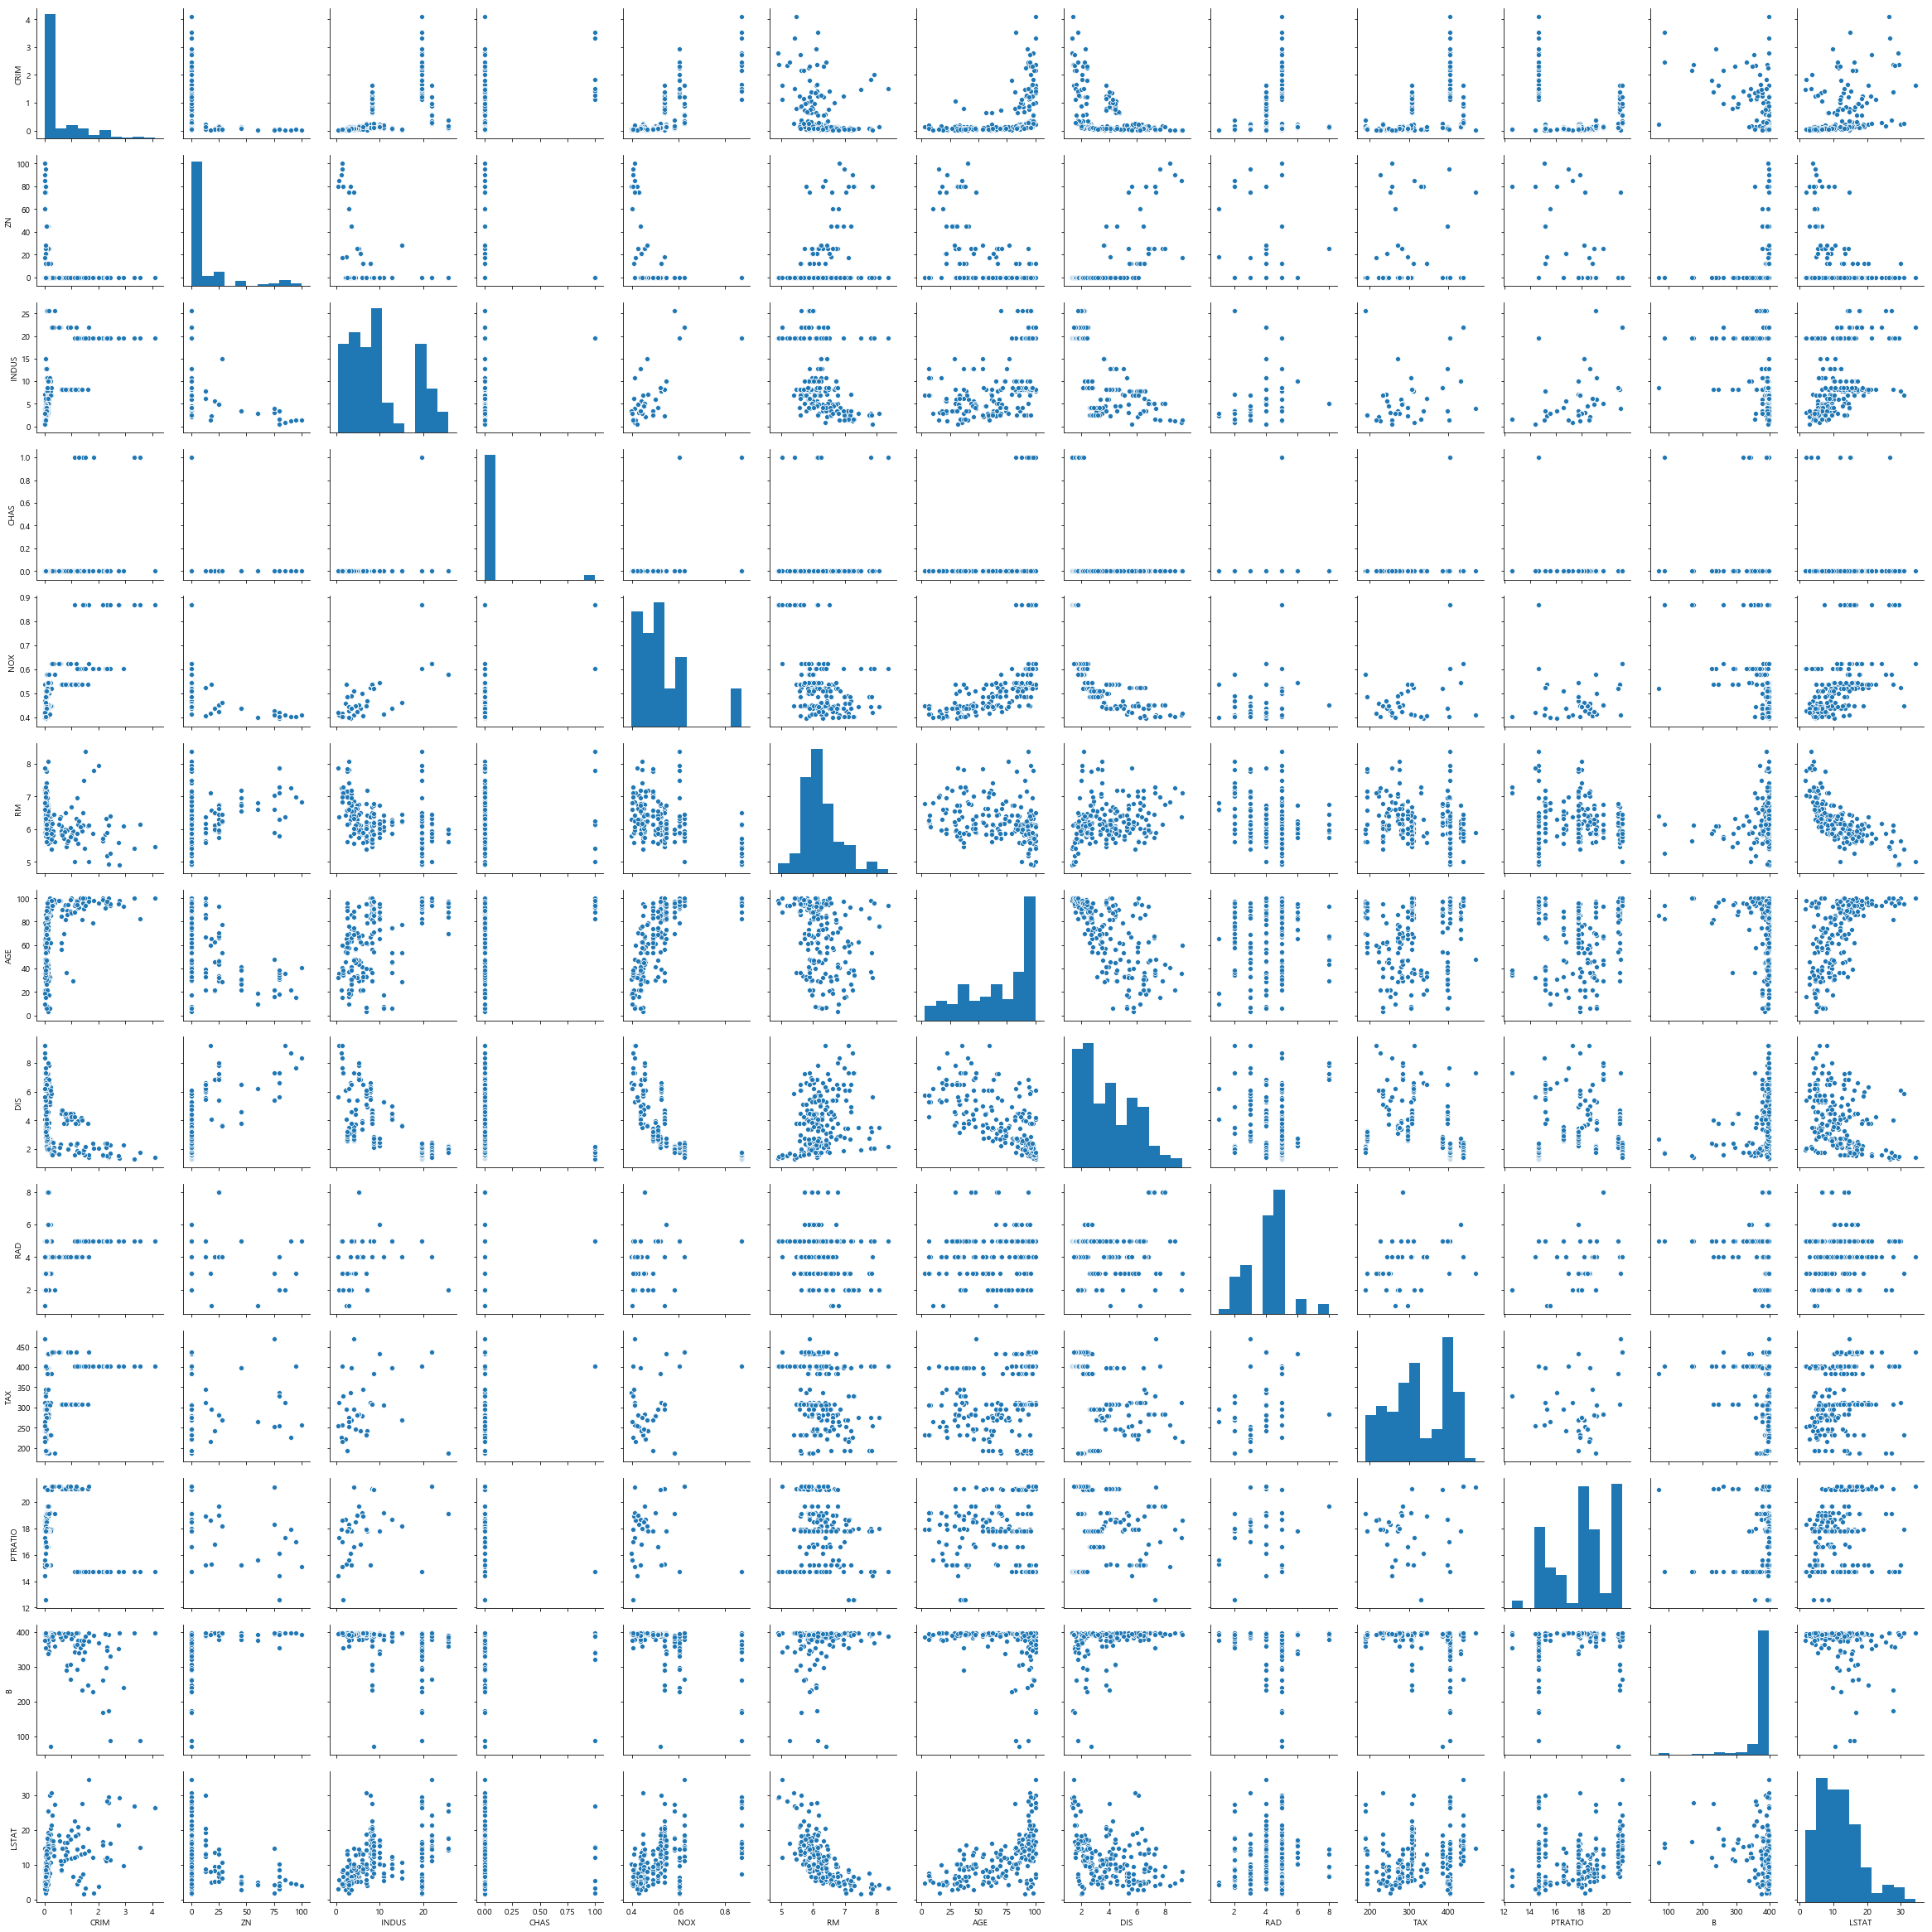

In [21]:
# 산점도 그려보기
sns.pairplot(housing_datasets[['CRIM', 'ZN' , 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']][:200])
plt.show()

**3. 목적변수 확인**


  + MEDV값의 원본(아래의 붉은 그래프)의 경우, 전반적으로는 정규분포를 따르나, 48~50사이의 값에서는 쏠린 경향이 확인됨
  + 이 때문에, 일반적인 다중회귀분석을 진행하기 전에, 관련 변수를 log변환을 진행함(아래 녹색 그래프)

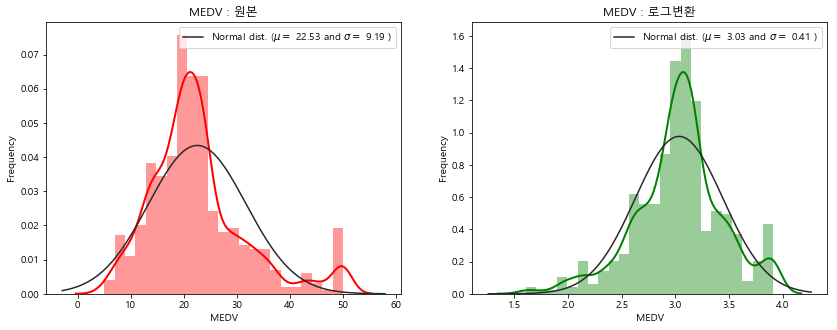

In [28]:
# EDA : 목적변수 분석
mpl.rc('figure', figsize=(14, 5))
plt.subplot(1,2,1)
sns.distplot(housing_datasets["MEDV"], hist=True, kde=True, color='red', kde_kws={'linewidth': 2} , fit=norm)
(mu, sigma) = norm.fit(housing_datasets["MEDV"])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('MEDV : 원본')

plt.subplot(1,2,2)
sns.distplot(np.log(housing_datasets["MEDV"]), hist=True, kde=True, color='green', kde_kws={'linewidth': 2} , fit=norm)
(mu, sigma) = norm.fit(np.log(housing_datasets["MEDV"]))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('MEDV : 로그변환')

plt.show()

**4. 모형1 : Regression**


  + 일반적인 다중회귀분석 모형은 유의한 모형으로 확인됨( Prob (F-statistic) = 0.00 )
  + 다만, 일부 변수의 계수(coef)는 유의미하지 않으므로, 불필요한 변수를 제거해 나가면서 모형을 작성하고자 함.
    (단, 반드시 포함시켜야 하는 변수가 없다는 것을 전제로 함)

In [29]:
# 데이터 분할
data_X = housing_datasets[['CRIM', 'ZN' , 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
data_Y = housing_datasets["MEDV"]
data_Y= np.log(data_Y)

# train/test data 나누기
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=0)

In [30]:
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     4909.
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:06:17   Log-Likelihood:                 4.7331
No. Observations:                 404   AIC:                             16.53
Df Residuals:                     391   BIC:                             68.55
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.0111      0.002     -5.567      0.0

**5. 모형1 조정 : Regression**


  + 조정된 다중회귀분석 모형 역시, 유의한 모형으로 확인됨( Prob (F-statistic) = 0.00 )
  + 아울러, BIC 값이 줄어들었으므로(68.55 $\to$ 65.75) 모형은 개선된 것으로 확인됨 
  + 그 외 회귀분석의 잔차 가정에 문제되는 내용이 없음
    + 잔차의 자기상관 : 없음(Durbin-Watson ~ 2.0)
    + 잔차의 정규성   : 없음(Prob(JB) < 0.00 )

In [31]:
feature = ['CRIM',  'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'B']

model = sm.OLS(y_train, X_train[feature]).fit()
predictions = model.predict(X_test[feature]) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     8521.
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:06:19   Log-Likelihood:                -11.869
No. Observations:                 404   AIC:                             37.74
Df Residuals:                     397   BIC:                             65.75
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.0151      0.002     -8.580      0.0

**6. 모형1 : 정리**


  + 예측 모형의 확인
    + 회귀분석 결과, 유의마한 모델이 도출되었으며, 모형은 전반적인 가정을 따름을 확인함.
    + 집값 예측모형은 MEDV = -0.015 x CRIM -0.0054 x NDUS + 0.1036 x CHAS + 0.6428 x NOX + 0.3888 x RM -0.0025 x AGE + 0.0014 x B


  + 주요 변수에 대한 설명
    + 유의미한 변수는 7개로, 각각 CRIM, INDUS, CHAS, NOX, RM, AGE, B 임
    + 즉, 산화 질소 농도(NOX)가 영향력이 높으며, 두번째로는 주거지 당 방의 평균겟수(RM)이 영향력이 높음
    + 비지니스 관점에서 해석하면, 차량이 많을수록(NOX) 그리고 방의 겟수가 많을수록 집값이 비싼데 영향이 높다고 결론지을 수 있다.

**6. 변수변환**
  + claasification을 진행하기 위해서는, MEDV 자료를 특정 구간으로 변환이 필요함
  + 즉, 목적 변수에 대해, category로 나누는 작업을 진행함.

In [32]:
housing_datasets['MEDV_CATEGORICAL'] = 0
housing_datasets['MEDV_CATEGORICAL']= pd.qcut(housing_datasets.MEDV, q=5)

In [33]:
housing_datasets.groupby('MEDV_CATEGORICAL')['MEDV'].count()

MEDV_CATEGORICAL
(4.999, 15.3]    102
(15.3, 19.7]     101
(19.7, 22.7]     101
(22.7, 28.2]     101
(28.2, 50.0]     101
Name: MEDV, dtype: int64

In [34]:
# df["Q36_CAT"] = df["Q36"].astype('category').cat.codes
housing_datasets['MEDV_CAT'] = housing_datasets['MEDV_CATEGORICAL'].astype('category').cat.codes
housing_datasets['MEDV_CAT'] = housing_datasets['MEDV_CAT'].astype('category')

In [35]:
housing_datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 16 columns):
CRIM                506 non-null float64
ZN                  506 non-null float64
INDUS               506 non-null float64
CHAS                506 non-null int64
NOX                 506 non-null float64
RM                  506 non-null float64
AGE                 506 non-null float64
DIS                 506 non-null float64
RAD                 506 non-null int64
TAX                 506 non-null float64
PTRATIO             506 non-null float64
B                   506 non-null float64
LSTAT               506 non-null float64
MEDV                506 non-null float64
MEDV_CATEGORICAL    506 non-null category
MEDV_CAT            506 non-null category
dtypes: category(2), float64(12), int64(2)
memory usage: 56.7 KB


**7. 모형2 : Decision tree 및 Random forest**
  + claasification의 대표적인 모형인 Decision tree 와 Random forest을 이용하여 분석함
  + 주요 결과를 보면, RM과 LSTAT가 중요도가 높은 변수로 확인됨

In [36]:
# 자료 전처리

feature= ['CRIM', 'ZN' , 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

data_X = housing_datasets[feature]
data_Y = housing_datasets["MEDV_CAT"]

# data split(train / test)
X1_train, X1_test, y1_train, y1_test = train_test_split(data_X, data_Y, test_size=0.8, random_state=0)

In [37]:
# 모형 실행 : Decision Tree
model_tree1 = DecisionTreeClassifier(criterion='entropy')
# model_tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)
model_tree1.fit(X1_train, y1_train)
importances1 = model_tree1.feature_importances_

# 모형 중요변수 : Decision Tree
df2_1_0 = pd.DataFrame(feature, columns =['feature'])
df2_1_1 = pd.DataFrame(importances1, columns =['importances'])
tree_model_1= pd.concat([df2_1_0, df2_1_1], axis=1)

# 모형 실행 : random forest
rf1 = RandomForestClassifier(n_estimators=1000, random_state=0)
rf1.fit(X1_train, y1_train)
importances2 = rf1.feature_importances_

# 모형 중요변수 : RF
df2_2_0 = pd.DataFrame(feature, columns =['feature'])
df2_2_1 = pd.DataFrame(importances1, columns =['importances'])
forest_model_1 = pd.concat([df2_2_0, df2_2_1], axis=1)

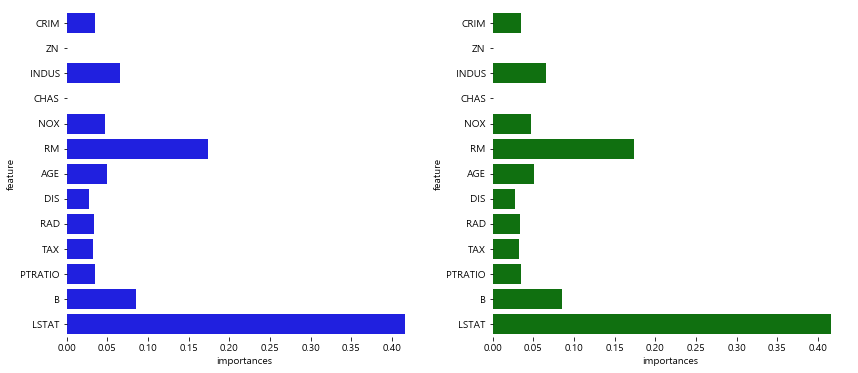

In [38]:
# 그래프 표기
mpl.rc('figure', figsize=(14, 6))

plt.subplot(1,2,1)
sns.barplot(y= tree_model_1['feature'], x= tree_model_1['importances'], color ='b')
sns.despine(left=True, bottom=True)

plt.subplot(1,2,2)
sns.barplot(y= forest_model_1['feature'], x= forest_model_1['importances'], color ='g')
sns.despine(left=True, bottom=True)

plt.show()

**7. 모형2 조정: Decision tree 및 Random forest**

  + 중요도가 낮은 변수를 제거 해도, 모형에는 큰 영향이 없음

In [39]:
# 자료 전처리
feature= [ 'INDUS', 'NOX', 'RM', 'AGE', 'DIS','TAX', 'PTRATIO', 'B', 'LSTAT']

data_X = housing_datasets[feature]
data_Y = housing_datasets["MEDV_CAT"]

# data split(train / test)
X1_train, X1_test, y1_train, y1_test = train_test_split(data_X, data_Y, test_size=0.8, random_state=0)


In [40]:
# 모형 실행 : Decision Tree
model_tree1 = DecisionTreeClassifier(criterion='entropy')
# model_tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)
model_tree1.fit(X1_train, y1_train)
importances1 = model_tree1.feature_importances_

# 모형 중요변수 : Decision Tree
df2_1_0 = pd.DataFrame(feature, columns =['feature'])
df2_1_1 = pd.DataFrame(importances1, columns =['importances'])
tree_model_1= pd.concat([df2_1_0, df2_1_1], axis=1)

# 모형 실행 : random forest
rf1 = RandomForestClassifier(n_estimators=1000, random_state=0)
rf1.fit(X1_train, y1_train)
importances2 = rf1.feature_importances_

# 모형 중요변수 : RF
df2_2_0 = pd.DataFrame(feature, columns =['feature'])
df2_2_1 = pd.DataFrame(importances1, columns =['importances'])
forest_model_1 = pd.concat([df2_2_0, df2_2_1], axis=1)

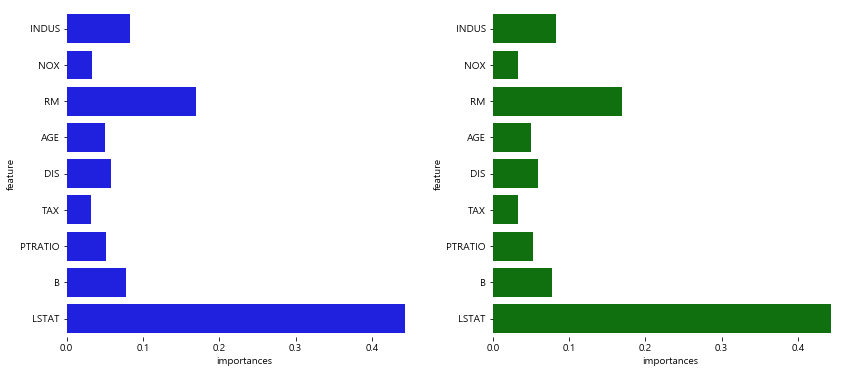

In [41]:
# 그래프 표기
mpl.rc('figure', figsize=(14, 6))

plt.subplot(1,2,1)
sns.barplot(y= tree_model_1['feature'], x= tree_model_1['importances'], color ='b')
sns.despine(left=True, bottom=True)

plt.subplot(1,2,2)
sns.barplot(y= forest_model_1['feature'], x= forest_model_1['importances'], color ='g')
sns.despine(left=True, bottom=True)

plt.show()

**8. 모형1 및 모형2 : 결론**

+ 모형의 활용
  + 회귀분석 및 분류분석의 결과는 상이하게 확인됨
  + 때문에, 1) 정확한 수치를 구하고자 할 경우에는 Regression 모형을 이용하고, 특정 범위를 구하고자 할 경우에는 classification 모형의 이용할 필요가 있음

+ 주요 변수 : 예측 모형의 비교
  + 회귀분석 모형의 경우, 1)산화 질소 농도(NOX) 및 2) 주거지 당 방의 평균겟수(RM)의 영향력이 높았음
  + 반변, 분류분석 모형의 경우, 3) 빈민의 비율(LSTA) 및 4) 주거지 당 방의 평균겟수(RM)
  + 두 모형에서 공통적으로 확인된 중요 변수는 `주거지 당 방의 평균겟수(RM)`로 확인됨 
